## This notebook is the baseline model using Bag of Words to generate features

In [46]:
import pandas as pd
import dgl 
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
# import scipy.sparse as sp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

#### 1. Read in files, and reduce problem statement to only nodes present in ground truth 

I've limited the sample space due to computational limitations. It will only consider the nodes and edges that have been labelled from the ground truth file

In [3]:
edges = pd.read_csv('input/Edges.csv', index_col=0)
ground = pd.read_csv('processed/ground_split.csv')
nodes = pd.read_csv('input/Nodes.csv', index_col=0)

In [4]:
# get all node names in the ground truth
unique_nodes = pd.DataFrame(set(ground.source).union(set(ground.target)), columns=['gt_nodes'])

# reduce problem statement to only take nodes that are in the source or target from the ground truth 
baseline_nodes = pd.merge(left=unique_nodes, right=nodes, left_on='gt_nodes', right_on='id', how='inner')
baseline_nodes = baseline_nodes[['id','name', 'category', 'description']]
baseline_nodes = baseline_nodes.reset_index()

# give new nodes a unique id - requirement of dgl
# note: dgl has support for named nodes but I was having issues here due to special characters
baseline_nodes_dict = dict(zip(baseline_nodes.id, baseline_nodes.index))

In [5]:
# map ground truth source and target names to ids provided by baseline node dictionary
ground.source = ground.source.apply(lambda x: baseline_nodes_dict[x])
ground.target = ground.target.apply(lambda x: baseline_nodes_dict[x])

#### 2. Split edges into train, test and validation sets

In [9]:
# train set - positive and negative nodes and edges
train_pos_u = np.array(ground[(ground.y==1) & (ground.split=='train')].source)
train_pos_v = np.array(ground[(ground.y==1) & (ground.split=='train')].target)

train_neg_u = np.array(ground[(ground.y==0) & (ground.split=='train')].source)
train_neg_v = np.array(ground[(ground.y==0) & (ground.split=='train')].target)

# val set - positive and negative nodes and edges
val_pos_u = np.array(ground[(ground.y==1) & (ground.split=='val')].source)
val_pos_v = np.array(ground[(ground.y==1) & (ground.split=='val')].target)

val_neg_u = np.array(ground[(ground.y==0) & (ground.split=='val')].source)
val_neg_v = np.array(ground[(ground.y==0) & (ground.split=='val')].target)

# test set - positive and negative nodes and edges
test_pos_u = np.array(ground[(ground.y==1) & (ground.split=='test')].source)
test_pos_v = np.array(ground[(ground.y==1) & (ground.split=='test')].target)

test_neg_u = np.array(ground[(ground.y==0) & (ground.split=='test')].source)
test_neg_v = np.array(ground[(ground.y==0) & (ground.split=='test')].target)


In [10]:
# reconstruct posive and negative graphs for train, test and validation
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=len(unique_nodes))
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=len(unique_nodes))

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=len(unique_nodes))
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=len(unique_nodes))

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=len(unique_nodes))
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=len(unique_nodes))

#### 3. Feature Extraction on Nodes

Features considered for this model are: 

1. Node type/category
2. Node Name + Description as BoW vector

In [11]:
# label encode category in baseline nodes
label_encoder = LabelEncoder()
baseline_nodes.category = label_encoder.fit_transform(baseline_nodes.category)

In [32]:
# turn description and names into features
# note: using BoW here, but I'm intentioanlly not doing additional processing beyond removing stop words
# I'm conscious that processsing capitalisation and intentional use of punctuation like D(2) or Calcipression-1
# might alter the meaning of the description significantly

# fill NaNs with empty string 
baseline_nodes.fillna('', inplace=True)

# join name and description to get more information 
baseline_nodes['full_description'] = baseline_nodes.name + ' ' + baseline_nodes.description

vectorizer = CountVectorizer(stop_words='english', lowercase=False, token_pattern=r"[a-zA-Z0-9_-]+", min_df=0.01)
bow = vectorizer.fit_transform(baseline_nodes.full_description)
bow = bow.toarray()
vocab = vectorizer.get_feature_names_out()


To utilise DGL's CSVDataset Class. Features must be saved under a single column named `feat`, consisting of a single 'array' saved as a string 

e.g. [Node Category, 5 word vector] -> "1, 0.56, 0.90, 0.85, 0.12, 0.82"

In [33]:
# create feature column 
feat_arr = np.c_[baseline_nodes.category.values, bow]
feat_arr = feat_arr.astype('float')
feat = []

# save features in the expected format
for f in feat_arr.tolist(): 
    f = str(f)
    f = f.replace('[', '')
    f = f.replace(']', '')
    feat = feat + [f]

baseline_nodes['feat'] = feat

#### 4. Save nodes, features and edges to graph

In [34]:
# save nodes and edges to baseline folder
baseline_nodes.rename({'index':'node_id'}, axis=1)[['node_id', 'feat']].to_csv('processed/baseline/baseline_nodes.csv', index=0)
ground[(ground.y==1)&(ground.split=='train')].rename({'source':'src_id', 'target':'dst_id'}, axis=1)[['src_id', 'dst_id']].to_csv('processed/baseline/baseline_edges.csv', index=0)

In [40]:
# load into dgl dataset tensor
dataset = dgl.data.CSVDataset('processed/baseline', force_reload=True)
g = dataset[0]

Done saving data into cached files.


#### 5. Define model and predictor

In [41]:
from dgl.nn import SAGEConv

# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [42]:
import dgl.function as fn


class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v("h", "h", "score"))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata["score"][:, 0]

In [87]:
from sklearn import metrics
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return F.binary_cross_entropy_with_logits(scores, labels)


def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()


    fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                    estimator_name='example estimator')
    
    display.plot()

    return roc_auc_score(labels, scores)

#### 6. Training and Evaluation

In [76]:
model = GraphSAGE(g.ndata["feat"].shape[1], 16)
pred = DotPredictor()

optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), pred.parameters()), lr=0.01
)


all_logits = []
train_loss_store = []
val_loss_store = []

for e in range(200):
    # forward
    h = model(g, g.ndata['feat'])
    train_pos_score = pred(train_pos_g, h)
    train_neg_score = pred(train_neg_g, h)
    train_loss = compute_loss(train_pos_score, train_neg_score)
    train_loss_store = train_loss_store + [train_loss.detach().item()]

    # backward
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # evaluate val loss and store 
    val_pos_score = pred(val_pos_g, h)
    val_neg_score = pred(val_neg_g, h)
    val_loss = compute_loss(val_pos_score, val_neg_score)
    val_loss_store = val_loss_store + [val_loss.detach().item()]


    if e % 10 == 0:
        print("In epoch {}, train loss: {}, val loss: {}".format(e, train_loss, val_loss))




In epoch 0, train loss: 1.7181769609451294, val loss: 1.743585228919983
In epoch 10, train loss: 0.5720990300178528, val loss: 0.5661841034889221
In epoch 20, train loss: 0.44317975640296936, val loss: 0.46365222334861755
In epoch 30, train loss: 0.35576626658439636, val loss: 0.390664666891098
In epoch 40, train loss: 0.3032337427139282, val loss: 0.3718283474445343
In epoch 50, train loss: 0.2636348605155945, val loss: 0.35700681805610657
In epoch 60, train loss: 0.23120273649692535, val loss: 0.3409288227558136
In epoch 70, train loss: 0.20966938138008118, val loss: 0.34212735295295715
In epoch 80, train loss: 0.19247430562973022, val loss: 0.34084805846214294
In epoch 90, train loss: 0.1775183528661728, val loss: 0.34565073251724243
In epoch 100, train loss: 0.16414521634578705, val loss: 0.3478551506996155
In epoch 110, train loss: 0.15352196991443634, val loss: 0.3539140224456787
In epoch 120, train loss: 0.14445547759532928, val loss: 0.3550816774368286
In epoch 130, train loss:

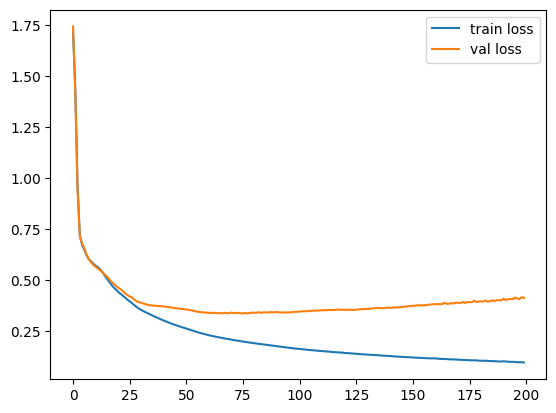

In [77]:
# plot training and validation loss over epochs
xs = [x for x in range(len(train_loss_store))]
plt.plot(xs, train_loss_store, label='train loss')
plt.plot(xs, val_loss_store, label='val loss')
plt.legend()
plt.show()

AUC 0.9549900968309859


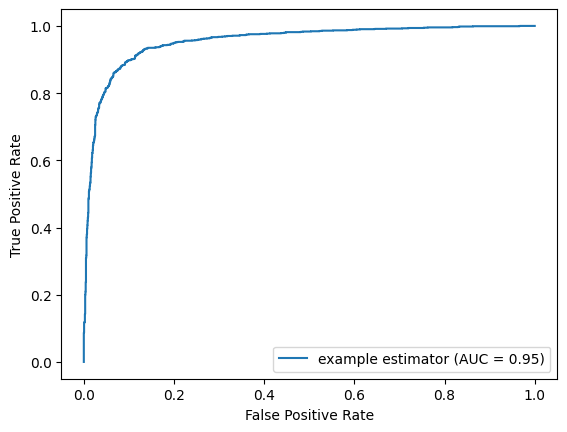

In [88]:
# Evaluate on Test Set
with torch.no_grad():
    test_pos_score = pred(test_pos_g, h)
    test_neg_score = pred(test_neg_g, h)
    print("AUC", compute_auc(test_pos_score, test_neg_score))

The AUC is very high at 0.95, and the ROC-AUC curve also appears to be very balanced, this gives confidence to the model's accuracy